## 3. Clustering for Semi Supervised Learning - Label Propogation <br>
<br>
<br>
So far we have managed to output clusters (hard clustering) and use soft clusters (distance from each cluster) as a preprocessing step to reduce dimensionality and improve performance. Now we will look at Clustering for Semi Supervised Learning which allows us to label our entire dataset by only labelling a small proportion of them manually.

<b> Introduction </b> <br>
Supervised learning is great when we have labelled data. Unfortunately most data we come to is unlabelled. We have already seen how unsupervised learning techniques are powerful ways to interpret unlabelled data. It can also be used to quickly label your data. This is semi supervised learning<br>

The term "Semi" supervised learning means there will be some labelling of instances, which is propogated throughout the remaining dataset. This can be extremely useful when we want to use a supervised technique and need to label instances.<br>

<b> Logic </b> <br>

The logic goes as follows:
- Find a number of representative cases (Defined by k, the number of clusters) <br>

In this notebook we work with images. Therefore if we set k to 50, we will find the distance from each of the 50 clusters. Each cluster represents a commonly found image in the huge dataset. This is soft clustering as seen previously
-  Find the centroids <br>

For each column (cluster), we will take the image that is closest to that cluster center (min value). Now we have one image that is representative of each cluster. 
- Manually label <br>

We manually label the 50 instances. Therefore we must output the images to do this. Once we have labelled the images we can automate the labelling of the remaining dataset!
- Automatic labelling <br>
We will say " Give all images in cluster 1, the same label as the centroid." Now we have taken the representative image and labelled ALL the images in the cluster.


#### 1. Import Relevant Packages

In [50]:
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

#### 2. Import Data

In [51]:
X_digits , y_digits = load_digits(return_X_y = True)

In [52]:
X_digits.shape

(1797, 64)

#### 3. Split into Training and Test Set

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state = 42)

#### 4. Finding Representative Images <br>

We have soft clustered our training dataset.

Here we will use clustering to find 50 representative images. If we find the value closest to the centroid/the centroid for each cluster we will have 50 images that strongly resemble that cluster.

In [54]:
X_train.shape

(1347, 64)

In [55]:
k = 50
kmeans = KMeans(n_clusters = k,  random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)                   

In [56]:
X_digits_dist.shape               #We have 50 columns(clusters) and 1347 images in the trainset
                                  #each column represents how close that image is each cluster
                                  

(1347, 50)

Below we will find the images that are closest to the cluster center (centroids). These are the most represetantive images of each of the 50 clusters (we specified 50 clusters, we could've done 60 or 70 etc..)

In [57]:
representative_digits_idx = np.argmin(X_digits_dist, axis = 0)         #np.argmin returns the index position of the lowest value each column
                                                                       #Since we specificed axis = 0 we will get the lowest value per column
                                                                       #Each column is a cluster so we should have 50 values at the end.

In [58]:
representative_digits_idx

array([1022, 1312,  535,  817,  704,   74,  175,  407,  753,  589,  841,
        194,  702,  737,  598,  481,   50,  937,  114,  159, 1056,  891,
        577, 1005,  731,  256, 1311,  205,   73, 1267, 1290,  325, 1343,
        357,   26,  559,  159,  137, 1057, 1194, 1235,  648,  525,  715,
        795,  771,  498, 1050,  855,  151], dtype=int64)

We use that list of index positions to extract all of the images we want

In [59]:
X_Representative_Images = X_train[representative_digits_idx]

In [60]:
X_Representative_Images.shape #As expected, 50 images with 64 columns. Each column is a pixel that can be reshaped to 8x8

(50, 64)

In [61]:
X_Representative_ImagesFinal = X_Representative_Images

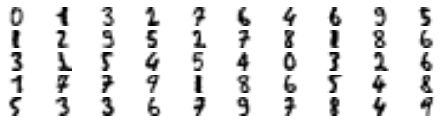

In [62]:
plt.figure(figsize=(8, 2))
for index, X_Representative_ImagesFinal in enumerate(X_Representative_ImagesFinal):
    plt.subplot(k // 10, 10, index + 1)                                 #k//10 = 5 rows, 10 columns, and index+1 is for the order.
    plt.imshow(X_Representative_ImagesFinal.reshape(8, 8), cmap="binary",interpolation="bilinear")
    plt.axis('off')

plt.show()

#### 5. Manually label those 50 Images
Remember this is semi supervised learning, meaning we must manually label some images. By finding 50 representative images we done already done a good job instead of randomly labelling images in the dataset.

In [63]:
y_representative_digits = np.array([4,8,0,6,8,3,7,7,9,2,
                                    5,5,8,5,2,1,2,5,6,3,
                                    1,6,9,0,8,3,0,7,4,1,
                                    6,5,2,4,1,8,6,3,9,2,
                                    4,2,9,4,7,6,2,3,1,9])

In [64]:
y_representative_digits.shape

(50,)

#### 5. Benchmark Model
Let's see how the model performs when we train this on random 50 images from the train set

In [65]:
from sklearn.linear_model import LogisticRegression
log_regbm = LogisticRegression(random_state =42, 
                               multi_class = "auto",
                               solver ='liblinear')


log_regbm.fit(X_train[:50], y_train[:50])
log_regbm.score(X_test,y_test)

0.8266666666666667

#### 6. Representative Model Score 
Let's see how the model performs when we train this on random 50 images from the train set

In [66]:
log_reg = LogisticRegression(random_state =42, 
                               multi_class = "auto",
                               solver ='liblinear')


log_reg.fit(X_Representative_Images, y_representative_digits)
log_reg.score(X_test, y_test)


0.14888888888888888

We can actually take this way further:
- Propogate the labels to the remaining data set (Label based on cluster and the image we already labelled)
- Remove the ones from the cluster boundary (These are likely to be labelled incorrectly remove labelled images that are close to boundary)

In [67]:
kmeans.labels_

array([13, 14, 26, ..., 39,  4, 10])

#### 7. Propogate the Labels to the rest of the data set

This improved the accuracy up to 89%!

In [68]:
y_train_propogated = np.empty(len(X_train), dtype =np.int32)                #Empty array size of the X_train of type np.int32

for i in range(k):
    y_train_propogated[kmeans.labels_ == i] = y_representative_digits[i]    

In [69]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propogated)
log_reg.score(X_test, y_test)

0.19555555555555557

#### 8. Remove the images at the boundary (Check if this is correct)

In [70]:
percentile_closest = 95

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [71]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propogated[partially_propagated]

In [72]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [73]:
log_reg.score(X_test, y_test)

0.20666666666666667